# **Match Song Lyrics to Artists**

In this assignment, you are asked to match song lyrics to their respective artists. Steps to the assignment:
1. Download the song lyrics. You can download the data from this link: https://www.kaggle.com/datasets/deepshah16/song-lyrics-dataset/data
1. Preprocess your dataset to your liking. You are free to use any preprocessing with any libraries. Make sure to apply the preprocessing to the whole dataset, even the test part.
1. Split your dataset into train/dev/test sets with 0.70/0.15/0.15 proportions. Select a random state number and use it consistently to get the same sets while iterating. **This is very important!**
1. Select your features for the task: word n-grams (unigram, bigram, trigram), character n-grams, TF-IDF, and so on.
1. Use three different approaches to solve the task: Some examples are Naive Bayes, Logistic Regression, SVM, KNNs, and neural networks classification methods with the dataset. **You need to select Naive Bayes as one of the methods and code Naive Bayes with the MLE approach from scratch.**
1. Compare different classification methods and show confusion matrices for each method.
1. Write a small report on your approaches and results.


## Rules
### Allowed:
 - Use any libraries for preprocessing, feature selection, vector making, training, and predicting for the task, **other than the Naive Bayes classifier**.
 - Adding additional coding blocks
 - Use spaCy for Named Entity Recognition and Part-of-Speech tagging (next week's content but will be helpful for this assignment)

### Not allowed:
 - Using metadata in the dataset given. You must use **only** the lyrics of the song. For example, do not use the release year to assign authorship.
 - **You need to write your own Naive Bayes classifier.** Using the Naive Bayes classifier from an external library is not allowed.
 - Running your code with the test split of your data. You can run this just before you submit your system. We will run your system on your test data in the evaluation.
 - Changing the contents of the evaluation block at the end of the notebook.
 - Using others' codes. We will check the overlaps across the submissions.

## Assignment Report
Please write a short assignment report at the end of the notebook (max 500 words). Please include all of the following points in the report:
 - Preprocessing method
 - Selection of the features and the reasoning for the selections
 - Selection of the classification methods and the reasoning for the selection
 - Challenges you have faced while writing the classifier
 - Limitations of your approach
 - Possible improvements to the system

## Grading
You will be graded with the following criteria:
 - running complete code (0.25),
 - clear commenting (0.25),
 - data loading and concatenation (0.5),
 - exploratory data analysis (EDA) - Artist Histogram Plot (0.5)
 - preprocessing function (0.5)
 - naive bayes implementation (1)
 - feature engineering (0.5)
 - model training and evaluation for at least 3 classification methods (including naive bayes) (1)
 - confusion matrix for each method (0.5)
 - assignment report (1).

Total points for this assignment = 6

## Submission

Submission will be made to SUCourse. Please submit your file using the following naming convention.


`studentid_studentname_tokenizer.ipynb  - ex. 26744_aysegulrana_tokenizer.ipynb`


**Deadline is November 7th, 23.55pm.**

### 1. Data Loading and Concatenation  (hint: use zipfile library for loading the zip file and concatenate the csv files)

Use pandas library to read your dataset into df object below.

In [ ]:
#####
#Download the lyrics from the link into your folder and read it with zip file
#Assign the file contents into df object that is from pandas library.
import pandas as pd
from pathlib import Path
import zipfile
import numpy as np

with zipfile.ZipFile('dataset.zip') as zf:
    zf.extractall()

csv_dir = Path('csv')
frames = []
for csv_file in sorted(csv_dir.glob('*.csv')):
    frame = pd.read_csv(csv_file)
    if 'Artist' not in frame.columns:
        frame['Artist'] = csv_file.stem
    frames.append(frame)

df = pd.concat(frames, ignore_index=True)


In [ ]:
df.head()

,Artist,Title,Album,Date,Lyric,Year,Unnamed: 0
0,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,thought i'd end up with sean but he wasn't a m...,2018.0,NaN
1,Ariana Grande,7 rings,"thank u, next",2019-01-18,yeah breakfast at tiffany's and bottles of bub...,2019.0,NaN
2,Ariana Grande,​God is a woman,Sweetener,2018-07-13,you you love it how i move you you love it how...,2018.0,NaN
3,Ariana Grande,Side To Side,Dangerous Woman,2016-05-20,ariana grande nicki minaj i've been here all ...,2016.0,NaN
4,Ariana Grande,​​no tears left to cry,Sweetener,2018-04-20,right now i'm in a state of mind i wanna be in...,2018.0,NaN


In [ ]:
len(df)

6027

### 2. Data Cleaning (Look at value count of each lyric and remove unnecessary or empty lyrics after this process view length of the dataframe to see the change)

In [ ]:
#   1. Remove missing or duplicate entries
#   2. Lowercase and remove punctuation
#   3. Filter out placeholder rows using regex
#   4. Use semantic similarity to remove "lyrics coming soon"-type placeholders

import re
import string
import torch
from sentence_transformers import SentenceTransformer, util

print("Starting cleaning process...")

# Ensure the expected column exists
if 'Lyric' not in df.columns:
    raise KeyError("Expected 'Lyric' column in DataFrame")

# Step 1: Remove rows with missing lyrics and extra whitespace
df = df[df['Lyric'].notna()].copy()
df['Lyric'] = df['Lyric'].astype(str).str.strip()

# Step 2: Normalize case and punctuation
# Convert all lyrics to lowercase and remove punctuation characters
translator = str.maketrans('', '', string.punctuation)
df['Lyric'] = df['Lyric'].str.lower().str.translate(translator)
# Replace multiple spaces or newlines with a single space
df['Lyric'] = df['Lyric'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Step 3: Remove duplicates to avoid bias during training
before = len(df)
df = df.drop_duplicates(subset=['Lyric']).reset_index(drop=True)
print(f"Removed {before - len(df)} duplicate lyrics")

# Step 4: Remove obvious placeholder rows using regex
# This detects generic messages like "lyrics coming soon" or "not yet released"
def regex_placeholder(text: str) -> bool:
    # Remove entries that are too short or contain no alphabetic characters
    if len(text) < 30 or not re.search(r'[a-z]', text):
        return True
    # Define regular expression patterns for known placeholder phrases
    patterns = [
        r'lyrics?\s+(coming|unavailable|tba|to\s+be\s+announced|to\s+be\s+released)',
        r'(coming|available)\s+soon',
        r'check\s+back\s+(soon|later)',
        r'not\s+been\s+released',
        r'be\s+the\s+first\s+to\s+add\s+the\s+lyrics',
        r'we\s+do\s+not\s+have\s+the\s+lyrics',
        r'will\s+be\s+(updated|released)\s+soon',
        r'song\s+coming\s+soon',
        r'no\s+lyrics\s+(yet|available)',
    ]
    # Return True if any placeholder pattern matches the lyric
    return any(re.search(pat, text) for pat in patterns)

# Apply the regex filtering function to the dataset
regex_mask = df['Lyric'].apply(regex_placeholder)
df_cleaned = df[~regex_mask].reset_index(drop=True)
print(f"Removed {regex_mask.sum()} regex placeholder rows")

# Step 5: Semantic placeholder removal using sentence embeddings
# This removes rows that are semantically similar to placeholder messages
placeholder_samples = [
    "lyrics coming soon",
    "lyrics will be released soon",
    "we do not have the lyrics yet",
    "no lyrics are available",
    "song lyrics not released",
    "check back later for lyrics"
]

print("Loading SentenceTransformer model (MiniLM)...")
model = SentenceTransformer("all-MiniLM-L6-v2")
placeholder_embs = model.encode(placeholder_samples, convert_to_tensor=True)

# Only check short lyrics (< 40 words), as longer lyrics are usually valid songs
short_mask = df_cleaned['Lyric'].map(lambda x: len(x.split()) < 40)
short_df = df_cleaned[short_mask].copy()

if len(short_df) > 0:
    print(f"Checking {len(short_df)} short lyrics for semantic placeholders...")
    # Compute cosine similarity between short lyrics and placeholder phrases
    text_embs = model.encode(short_df['Lyric'].tolist(), convert_to_tensor=True)
    cosine_sim = util.cos_sim(text_embs, placeholder_embs).cpu().numpy()
    # Get maximum similarity for each lyric
    max_sim = cosine_sim.max(axis=1)
    # Identify rows with similarity above the 0.75 threshold
    semantic_mask = max_sim > 0.75
    print(f"Removed {semantic_mask.sum()} semantically similar placeholder rows")
    # Drop rows that are semantically too close to placeholder phrases
    to_remove_idx = short_df.index[semantic_mask]
    df_cleaned = df_cleaned.drop(to_remove_idx).reset_index(drop=True)

# Step 6: Final cleaned DataFrame
# Store the result back to df for consistency
df = df_cleaned.copy()
print(f"Final cleaned lyrics: {len(df)} rows remaining")

Starting cleaning process...
Removed 389 duplicate lyrics
Removed 52 regex placeholder rows
Loading SentenceTransformer model (MiniLM)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Checking 161 short lyrics for semantic placeholders...
Removed 11 semantically similar placeholder rows
Final cleaned lyrics: 5529 rows remaining


### 3. Exploratory Data Analysis (EDA) - Artist Histogram (Create a histogram for the number of lyrics of each artist using matplotlib)

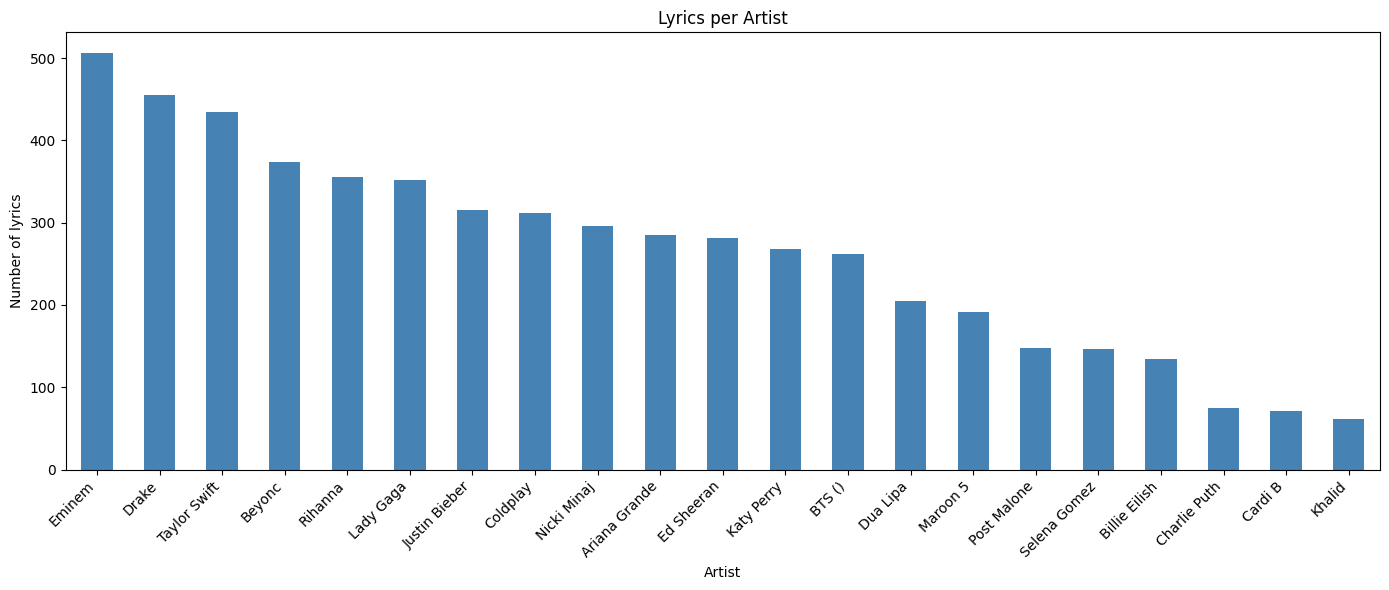

In [ ]:
import matplotlib.pyplot as plt

artist_counts = df['Artist'].value_counts().sort_values(ascending=False)
artist_counts.index = artist_counts.index.str.encode('ascii', 'ignore').str.decode('ascii')

plt.figure(figsize=(14, 6))
artist_counts.plot(kind='bar', color='steelblue')
plt.xlabel('Artist')
plt.ylabel('Number of lyrics')
plt.title('Lyrics per Artist')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


### 4. Preprocessing Function (Create a preprocess function for the lyrics)

In [ ]:
import spacy

# Load spaCy model for lemmatization and stopword removal
# We disable parser and NER to make processing faster since we only need tokens and lemmas
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_data(df):
    """
    This step applies linguistic normalization suitable for
    Naive Bayes and Logistic Regression.

    I already performed steps such as lowercasing, punctuation removal, and
    duplicate removal in the cleaning step, so this
    function focuses on:
        - Lemmatization: reducing words to their base forms
        - Stopword removal: eliminating very common non-informative words
          (e.g., 'the', 'and', 'is') to improve feature quality
    """
    df = df.copy()
    df["Lyric"] = df["Lyric"].astype(str)

    processed_lyrics = []

    # Iterate over each lyric and apply spaCy pipeline
    for text in df["Lyric"]:
        doc = nlp(text)
        # Keep only alphabetic tokens and remove stopwords
        # Replace each token with its lemma
        tokens = [
            token.lemma_
            for token in doc
            if token.is_alpha and not token.is_stop
        ]
        # Join tokens back into a single processed string
        processed_lyrics.append(" ".join(tokens))

    # Assign processed lyrics back to DataFrame
    df["Lyric"] = processed_lyrics

    # Display sample output
    print("Preprocessing complete. Sample processed lyrics:")
    print(df["Lyric"].sample(3).tolist())

    return df

# Apply function
df = preprocess_data(df)

Preprocessing complete. Sample processed lyrics:
['oh brother not not ve tryin hard reach cause not know oh brother not believe true m scared future wanna talk oh wanna talk picture future climb ladder sun write song sing s lose incomplete feel like puzzle not find miss piece tell feel feel like talkin language not speak talk picture future climb ladder sun write song sing s s not know go wanna talk feel like go ve ll tell ll listen feel ignore nothing makin sense let talk let talk let talk let talk', 'm penthouse halfnake cook meal naked hell shot leave drink glass not break wish feel feeling break promise know honest get yell s m jealous keep promise m keep oh m jealous keep promise m keep oh m jealous post wanna walk shoe type thing look mirror baby girl not survive like step freakum dress closet yoncé fillin skirt look damn good be not lose be not miss beat boy hang night tonight m stay til tomorrow dance table be not get care sorrow run ex say bestie reminisce flex texas not jealo

#### Train Dev Test split
Separate the song lyrics (documents) with respective artist names (labels). Split the dataset into train/dev/test datasets with 0.70/0.15/0.15 proportions.

In [ ]:
# === TRAIN / DEV / TEST SPLITS FOR BOTH DATASETS ===
# Classical models (NB, Logistic, SVM) -> df (the cleaned and preproccessed)
# Neural model (LSTM) -> df_cleaned (just cleaned no lemmitiation or stopword removal)
# =====================================================

from sklearn.model_selection import train_test_split

# --- for Naive Bayes / Logistic Regression
print("Splitting data for classical models (Naive Bayes, Logistic Regression)")

X_proc = df["Lyric"]
y_proc = df["Artist"]

# 70% train, 30% temp (dev + test)
X_train_proc, X_temp_proc, y_train_proc, y_temp_proc = train_test_split(
    X_proc, y_proc,
    test_size=0.30,
    random_state=42,
    stratify=y_proc
)

# spliting remaining 30% evenly into dev (15%) and test (15%)
X_dev_proc, X_test_proc, y_dev_proc, y_test_proc = train_test_split(
    X_temp_proc, y_temp_proc,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_proc
)

# reset indices
X_train_proc = X_train_proc.reset_index(drop=True)
X_dev_proc   = X_dev_proc.reset_index(drop=True)
X_test_proc  = X_test_proc.reset_index(drop=True)
y_train_proc = y_train_proc.reset_index(drop=True)
y_dev_proc   = y_dev_proc.reset_index(drop=True)
y_test_proc  = y_test_proc.reset_index(drop=True)

print(f"Classical data split -> Train: {len(X_train_proc)}, Dev: {len(X_dev_proc)}, Test: {len(X_test_proc)}")


# --- Neural model: LSTM ---
print("\nSplitting data for neural model (LSTM)")

X_lstm = df_cleaned["Lyric"]
y_lstm = df_cleaned["Artist"]

# 70% train, 30% temp (dev + test)
X_train_lstm, X_temp_lstm, y_train_lstm, y_temp_lstm = train_test_split(
    X_lstm, y_lstm,
    test_size=0.30,
    random_state=42,
    stratify=y_lstm
)

# split remaining 30% evenly into dev and test
X_dev_lstm, X_test_lstm, y_dev_lstm, y_test_lstm = train_test_split(
    X_temp_lstm, y_temp_lstm,
    test_size=0.50,
    random_state=42,
    stratify=y_temp_lstm
)

# reset indices
X_train_lstm = X_train_lstm.reset_index(drop=True)
X_dev_lstm   = X_dev_lstm.reset_index(drop=True)
X_test_lstm  = X_test_lstm.reset_index(drop=True)
y_train_lstm = y_train_lstm.reset_index(drop=True)
y_dev_lstm   = y_dev_lstm.reset_index(drop=True)
y_test_lstm  = y_test_lstm.reset_index(drop=True)

print(f"LSTM data split -> Train: {len(X_train_lstm)}, Dev: {len(X_dev_lstm)}, Test: {len(X_test_lstm)}")


Splitting data for classical models (Naive Bayes, Logistic Regression)
Classical data split -> Train: 3870, Dev: 829, Test: 830

Splitting data for neural model (LSTM)
LSTM data split -> Train: 3870, Dev: 829, Test: 830


### 5. Implement a Naive Bayes classifier with Bag-of-Words features **from** scratch. You are not allowed to use external libraries for training a NB classifier.


=== Naive Bayes on Lemmatized (preprocessed) ===
Alpha=0.5: Dev Weighted F1 = 0.6912
Alpha=1.0: Dev Weighted F1 = 0.6655
Alpha=2.0: Dev Weighted F1 = 0.6028
Best alpha for Lemmatized (preprocessed): 0.5
[Lemmatized (preprocessed)] Test Accuracy = 0.7349 | Weighted F1 = 0.7280

=== Naive Bayes on Cleaned (non-lemmatized, with stopwords) ===
Alpha=0.5: Dev Weighted F1 = 0.6808
Alpha=1.0: Dev Weighted F1 = 0.6656
Alpha=2.0: Dev Weighted F1 = 0.6361
Best alpha for Cleaned (non-lemmatized, with stopwords): 0.5
[Cleaned (non-lemmatized, with stopwords)] Test Accuracy = 0.7349 | Weighted F1 = 0.7319


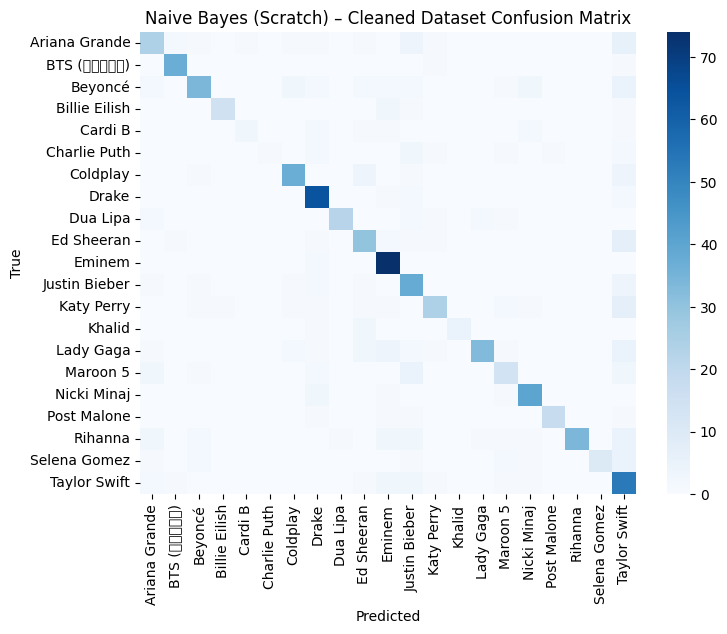


 Summary:
Lemmatized → Acc=0.7349, F1=0.7280
Cleaned    → Acc=0.7349, F1=0.7319


In [ ]:
# ================================================================
# NAIVE BAYES FROM SCRATCH — Lemmatized vs Cleaned Comparison
# ================================================================
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ------------------------------------------------
# Naive Bayes Implementation
# ------------------------------------------------
class MultinomialNBScratch:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    def fit(self, X, y):
        X = sp.csr_matrix(X, dtype=np.float64)
        n_docs, V = X.shape
        classes = np.unique(y)
        C = len(classes)
        class_counts = np.bincount(y, minlength=C).astype(np.float64)
        self.class_log_prior_ = np.log(class_counts / n_docs)
        feature_count = np.zeros((C, V), dtype=np.float64)
        for c in range(C):
            feature_count[c, :] = X[y == c].sum(axis=0)
        smoothed_fc = feature_count + self.alpha
        norm = smoothed_fc.sum(axis=1, keepdims=True)
        self.feature_log_prob_ = np.log(smoothed_fc / norm)
        self.classes_ = classes
        return self
    def _joint_log_likelihood(self, X):
        return self.class_log_prior_ + X @ self.feature_log_prob_.T
    def predict(self, X):
        return np.argmax(self._joint_log_likelihood(X), axis=1)

# ------------------------------------------------
# Helper function to train + evaluate one dataset
# ------------------------------------------------
def run_nb_experiment(name, X_train, X_dev, X_test, y_train, y_dev, y_test):
    print(f"\n=== Naive Bayes on {name} ===")
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        min_df=3,
        max_features=40000
    )

    X_train_bow = vectorizer.fit_transform(X_train)
    X_dev_bow   = vectorizer.transform(X_dev)
    X_test_bow  = vectorizer.transform(X_test)

    # Encode labels to indices
    classes, y_train_idx = np.unique(y_train, return_inverse=True)
    class_to_idx = {c: i for i, c in enumerate(classes)}
    y_dev_idx  = np.array([class_to_idx[c] for c in y_dev])
    y_test_idx = np.array([class_to_idx[c] for c in y_test])

    # Hyperparameter search
    alphas = [0.5, 1.0, 2.0]
    best_alpha, best_f1 = None, -1
    for a in alphas:
        nb = MultinomialNBScratch(alpha=a).fit(X_train_bow, y_train_idx)
        preds_dev = nb.predict(X_dev_bow)
        f1_dev = f1_score(y_dev_idx, preds_dev, average="weighted")
        print(f"Alpha={a}: Dev Weighted F1 = {f1_dev:.4f}")
        if f1_dev > best_f1:
            best_alpha, best_f1 = a, f1_dev

    print(f"Best alpha for {name}: {best_alpha}")

    # Retrain on train + dev
    X_trdev = sp.vstack([X_train_bow, X_dev_bow])
    y_trdev = np.concatenate([y_train_idx, y_dev_idx])
    nb_final = MultinomialNBScratch(alpha=best_alpha).fit(X_trdev, y_trdev)

    # Evaluate on test
    preds_test = nb_final.predict(X_test_bow)
    acc = accuracy_score(y_test_idx, preds_test)
    f1 = f1_score(y_test_idx, preds_test, average="weighted")
    print(f"[{name}] Test Accuracy = {acc:.4f} | Weighted F1 = {f1:.4f}")
    return preds_test, y_test_idx, classes, acc, f1


# ------------------------------------------------
# Run for both datasets
# ------------------------------------------------
preds_lemma, y_test_lemma, classes_lemma, acc_lemma, f1_lemma = run_nb_experiment(
    "Lemmatized (preprocessed)",
    X_train_proc, X_dev_proc, X_test_proc,
    y_train_proc, y_dev_proc, y_test_proc
)

preds_clean, y_test_clean, classes_clean, acc_clean, f1_clean = run_nb_experiment(
    "Cleaned (non-lemmatized, with stopwords)",
    X_train_lstm, X_dev_lstm, X_test_lstm,
    y_train_lstm, y_dev_lstm, y_test_lstm
)

# ------------------------------------------------
# Choose best and plot confusion matrix
# ------------------------------------------------
if f1_clean > f1_lemma:
    best_name, best_preds, best_y, best_classes = "Cleaned", preds_clean, y_test_clean, classes_clean
else:
    best_name, best_preds, best_y, best_classes = "Lemmatized", preds_lemma, y_test_lemma, classes_lemma

cm = confusion_matrix(best_y, best_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=best_classes, yticklabels=best_classes)
plt.title(f"Naive Bayes (Scratch) – {best_name} Dataset Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\n Summary:")
print(f"Lemmatized → Acc={acc_lemma:.4f}, F1={f1_lemma:.4f}")
print(f"Cleaned    → Acc={acc_clean:.4f}, F1={f1_clean:.4f}")


### 6. Feature Selection and Engineering for other two classification methods - Select your features and convert your data with respect to these features. For example, if you will use numerical representation, use appropriate methods to transform your data to vectors.

In [ ]:
# Avg length of lyrics
avg_len = int(np.mean([len(t.split()) for t in X_train_lstm]))
print(avg_len)

396


In [ ]:
# ================================================================
# FEATURE EXTRACTION PIPELINE
# ================================================================
# (A) TF-IDF FEATURES  — for Logistic Regression / SVM
# (B) TOKENIZED SEQUENCES  — for LSTM
# ================================================================

from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scipy.sparse import hstack

# ================================================================
# (A1) WORD-LEVEL TF-IDF (lemmatized dataset)
# ================================================================
# Captures word and phrase-level semantics (useful for LogReg/SVM)

vectorizer_word = TfidfVectorizer(
    analyzer='word',
    ngram_range=(1, 3),      # unigrams, bigrams, trigrams
    min_df=3,
    max_df=0.8,
    max_features=40000,
    sublinear_tf=True,
    norm='l2'
)

print("Fitting word-level TF-IDF on lemmatized lyrics...")
X_train_tfidf_word = vectorizer_word.fit_transform(X_train_proc)
X_dev_tfidf_word   = vectorizer_word.transform(X_dev_proc)
X_test_tfidf_word  = vectorizer_word.transform(X_test_proc)

print(f"Word TF-IDF matrix shape: {X_train_tfidf_word.shape}")
print(f"Word TF-IDF vocab size: {len(vectorizer_word.get_feature_names_out())}")

# ================================================================
# (A2) CHARACTER-LEVEL TF-IDF (cleaned dataset)
# ================================================================
# Captures stylistic cues (punctuation, repetition, spelling)
# Great for authorship and lyric style identification.

vectorizer_char = TfidfVectorizer(
    analyzer='char_wb',       # character n-grams inside word boundaries
    ngram_range=(3, 5),       # 3- to 5-character sequences
    min_df=3,
    max_features=40000,
    sublinear_tf=True,
    norm='l2'
)

print("Fitting char-level TF-IDF on cleaned lyrics...")
X_train_tfidf_char = vectorizer_char.fit_transform(X_train_lstm)
X_dev_tfidf_char   = vectorizer_char.transform(X_dev_lstm)
X_test_tfidf_char  = vectorizer_char.transform(X_test_lstm)

print(f"Char TF-IDF matrix shape: {X_train_tfidf_char.shape}")
print(f"Char TF-IDF vocab size: {len(vectorizer_char.get_feature_names_out())}")

# ================================================================
# (A3) HYBRID TF-IDF (WORD + CHAR)
# ================================================================
# Combine both representations for a stronger model (SVM usually benefits most)

from scipy.sparse import hstack
X_train_tfidf_hybrid = hstack([X_train_tfidf_word, X_train_tfidf_char])
X_dev_tfidf_hybrid   = hstack([X_dev_tfidf_word,   X_dev_tfidf_char])
X_test_tfidf_hybrid  = hstack([X_test_tfidf_word,  X_test_tfidf_char])

print(f"Hybrid TF-IDF feature shape (train): {X_train_tfidf_hybrid.shape}")

# ================================================================
# (B) TOKENIZED SEQUENCES  — for LSTM
# ================================================================
# Use the CLEANED dataset (no lemmatization or stopword removal)
# to preserve rhythm, repetition, and ordering.

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=40000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train_lstm)

# Convert texts → integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_lstm)
X_dev_seq   = tokenizer.texts_to_sequences(X_dev_lstm)
X_test_seq  = tokenizer.texts_to_sequences(X_test_lstm)

# Pad/truncate each lyric to fixed length
MAX_LEN = 400
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_dev_pad   = pad_sequences(X_dev_seq,   maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

vocab_size = min(40000, len(tokenizer.word_index) + 1)
print(f"Tokenizer vocab size: {vocab_size}")
print(f"Sequence matrix (train) shape: {X_train_pad.shape}")

# ================================================================
# SUMMARY
# ================================================================
# Logistic Regression / SVM (semantic):  X_train_tfidf_word
# Logistic Regression / SVM (stylistic): X_train_tfidf_char
# Logistic Regression / SVM (hybrid):    X_train_tfidf_hybrid
# LSTM (sequence-based):                 X_train_pad
# ================================================================


Fitting word-level TF-IDF on lemmatized lyrics...
Word TF-IDF matrix shape: (3870, 40000)
Word TF-IDF vocab size: 40000
Fitting char-level TF-IDF on cleaned lyrics...
Char TF-IDF matrix shape: (3870, 40000)
Char TF-IDF vocab size: 40000
Hybrid TF-IDF feature shape (train): (3870, 80000)
Tokenizer vocab size: 40000
Sequence matrix (train) shape: (3870, 400)


### 7. Model Training and Evaluation
#### - Use several models to train on the dataset
#### - Use development dataset to see your system performances and optimize your system as you want.
#### - Lastly, evaluate your results with accuracy and F1 scores using test set.
#### - Report on the performance on the test set with comparison between methods and confusion matrices.

=== Logistic Regression: Word, Char, and Hybrid TF-IDF Comparison ===

Training on Word-level TF-IDF (lemmatized)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogReg (Word TF-IDF)]  Dev F1 = 0.7333 | Test Acc = 0.7663 | Test F1 = 0.7638

Training on Char-level TF-IDF (cleaned lyrics)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogReg (Char TF-IDF)]  Dev F1 = 0.7394 | Test Acc = 0.7759 | Test F1 = 0.7701

Training on Hybrid TF-IDF (word + char features)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[LogReg (Hybrid TF-IDF)]  Dev F1 = 0.7559 | Test Acc = 0.8012 | Test F1 = 0.7974

 Best Model: Hybrid TF-IDF
Test Accuracy = 0.8012 | Weighted F1 = 0.7974


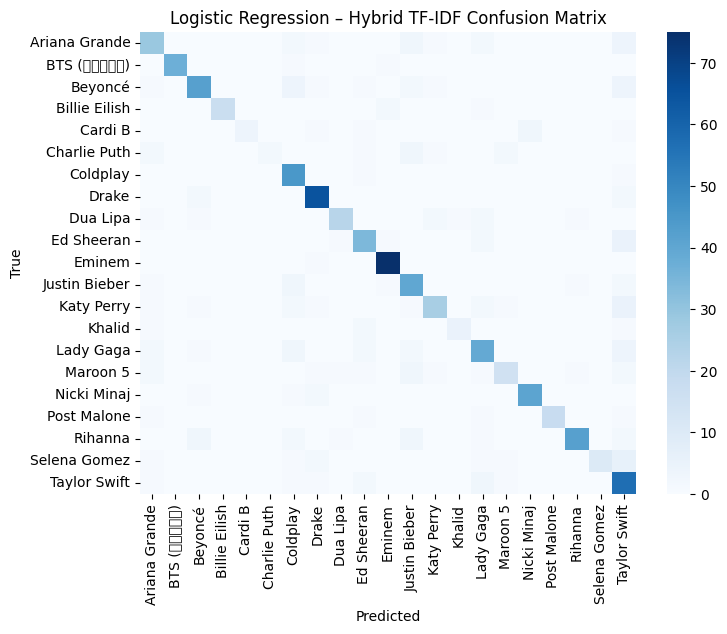

In [ ]:
# ================================================================
# LOGISTIC REGRESSION TRAINING AND EVALUATION
# ================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("=== Logistic Regression: Word, Char, and Hybrid TF-IDF Comparison ===")

# ------------------------------------------------
# Helper function for training + evaluation
# ------------------------------------------------
def evaluate_logreg(name, X_train, X_dev, X_test, y_train, y_dev, y_test):
    model = LogisticRegression(
        C=2.0,
        max_iter=1000,
        solver='lbfgs',
        multi_class='multinomial',
        n_jobs=-1
    )
    model.fit(X_train, y_train)

    # Validation
    preds_dev = model.predict(X_dev)
    f1_dev = f1_score(y_dev, preds_dev, average="weighted")

    # Retrain on train+dev
    X_trdev = vstack([X_train, X_dev])
    y_trdev = np.concatenate([y_train, y_dev])
    model.fit(X_trdev, y_trdev)

    # Test
    preds_test = model.predict(X_test)
    acc = accuracy_score(y_test, preds_test)
    f1 = f1_score(y_test, preds_test, average="weighted")

    print(f"[{name}]  Dev F1 = {f1_dev:.4f} | Test Acc = {acc:.4f} | Test F1 = {f1:.4f}")
    return model, preds_test, acc, f1


# ------------------------------------------------
# Train three Logistic Regression variants
# ------------------------------------------------
results = {}

# Word-level TF-IDF
print("\nTraining on Word-level TF-IDF (lemmatized)...")
model_word, preds_word, acc_word, f1_word = evaluate_logreg(
    "LogReg (Word TF-IDF)",
    X_train_tfidf_word, X_dev_tfidf_word, X_test_tfidf_word,
    y_train_proc, y_dev_proc, y_test_proc
)
results["Word TF-IDF"] = (model_word, preds_word, acc_word, f1_word)

# Char-level TF-IDF
print("\nTraining on Char-level TF-IDF (cleaned lyrics)...")
model_char, preds_char, acc_char, f1_char = evaluate_logreg(
    "LogReg (Char TF-IDF)",
    X_train_tfidf_char, X_dev_tfidf_char, X_test_tfidf_char,
    y_train_lstm, y_dev_lstm, y_test_lstm
)
results["Char TF-IDF"] = (model_char, preds_char, acc_char, f1_char)

# Hybrid TF-IDF (Word + Char)
print("\nTraining on Hybrid TF-IDF (word + char features)...")
model_hybrid, preds_hybrid, acc_hybrid, f1_hybrid = evaluate_logreg(
    "LogReg (Hybrid TF-IDF)",
    X_train_tfidf_hybrid, X_dev_tfidf_hybrid, X_test_tfidf_hybrid,
    y_train_lstm, y_dev_lstm, y_test_lstm
)
results["Hybrid TF-IDF"] = (model_hybrid, preds_hybrid, acc_hybrid, f1_hybrid)


# ------------------------------------------------
# Compare results and find the best-performing model
# ------------------------------------------------
best_name = max(results, key=lambda k: results[k][3])  # by Test F1
best_model, best_preds, best_acc, best_f1 = results[best_name]

print("\n Best Model:", best_name)
print(f"Test Accuracy = {best_acc:.4f} | Weighted F1 = {best_f1:.4f}")

# ------------------------------------------------
# Confusion matrix for the best model
# ------------------------------------------------
if "Word" in best_name:
    y_true = y_test_proc
elif "Char" in best_name or "Hybrid" in best_name:
    y_true = y_test_lstm

cm = confusion_matrix(y_true, best_preds, labels=np.unique(y_true))

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.title(f"Logistic Regression – {best_name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


=== SVM: Word, Char, and Hybrid TF-IDF Comparison ===

Training on Word-level TF-IDF (lemmatized)...
[SVM (Word TF-IDF)]  Dev F1 = 0.7617 | Test Acc = 0.7988 | Test F1 = 0.7975

Training on Char-level TF-IDF (cleaned lyrics)...
[SVM (Char TF-IDF)]  Dev F1 = 0.7551 | Test Acc = 0.8036 | Test F1 = 0.8007

Training on Hybrid TF-IDF (word + char features)...
[SVM (Hybrid TF-IDF)]  Dev F1 = 0.7754 | Test Acc = 0.8229 | Test F1 = 0.8209

 Best Model: Hybrid TF-IDF
Test Accuracy = 0.8229 | Weighted F1 = 0.8209


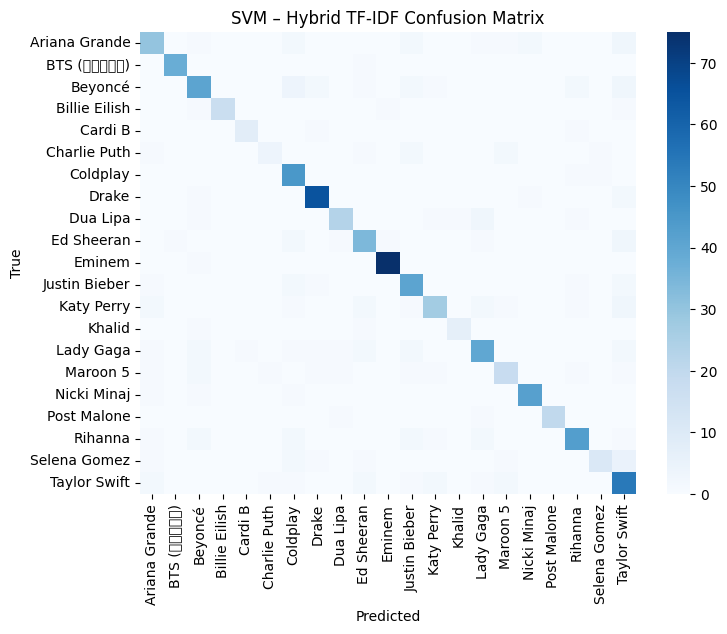

In [ ]:
# ================================================================
# SUPPORT VECTOR MACHINE (SVM) — WORD, CHAR, HYBRID TF-IDF COMPARISON
# ================================================================
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print("=== SVM: Word, Char, and Hybrid TF-IDF Comparison ===")

# ------------------------------------------------
# Helper function for training + evaluation
# ------------------------------------------------
def evaluate_svm(name, X_train, X_dev, X_test, y_train, y_dev, y_test):
    model = LinearSVC(C=2.0, max_iter=5000)
    model.fit(X_train, y_train)

    # Validation
    preds_dev = model.predict(X_dev)
    f1_dev = f1_score(y_dev, preds_dev, average="weighted")

    # Retrain on train+dev
    X_trdev = vstack([X_train, X_dev])
    y_trdev = np.concatenate([y_train, y_dev])
    model.fit(X_trdev, y_trdev)

    # Test
    preds_test = model.predict(X_test)
    acc = accuracy_score(y_test, preds_test)
    f1 = f1_score(y_test, preds_test, average="weighted")

    print(f"[{name}]  Dev F1 = {f1_dev:.4f} | Test Acc = {acc:.4f} | Test F1 = {f1:.4f}")
    return model, preds_test, acc, f1


# ------------------------------------------------
# Train three SVM variants
# ------------------------------------------------
results = {}

# 1️⃣ Word-level TF-IDF (Lemmatized)
print("\nTraining on Word-level TF-IDF (lemmatized)...")
svm_word, preds_word, acc_word, f1_word = evaluate_svm(
    "SVM (Word TF-IDF)",
    X_train_tfidf_word, X_dev_tfidf_word, X_test_tfidf_word,
    y_train_proc, y_dev_proc, y_test_proc
)
results["Word TF-IDF"] = (svm_word, preds_word, acc_word, f1_word)

# 2️⃣ Char-level TF-IDF (Cleaned)
print("\nTraining on Char-level TF-IDF (cleaned lyrics)...")
svm_char, preds_char, acc_char, f1_char = evaluate_svm(
    "SVM (Char TF-IDF)",
    X_train_tfidf_char, X_dev_tfidf_char, X_test_tfidf_char,
    y_train_lstm, y_dev_lstm, y_test_lstm
)
results["Char TF-IDF"] = (svm_char, preds_char, acc_char, f1_char)

# 3️⃣ Hybrid TF-IDF (Word + Char)
print("\nTraining on Hybrid TF-IDF (word + char features)...")
svm_hybrid, preds_hybrid, acc_hybrid, f1_hybrid = evaluate_svm(
    "SVM (Hybrid TF-IDF)",
    X_train_tfidf_hybrid, X_dev_tfidf_hybrid, X_test_tfidf_hybrid,
    y_train_lstm, y_dev_lstm, y_test_lstm
)
results["Hybrid TF-IDF"] = (svm_hybrid, preds_hybrid, acc_hybrid, f1_hybrid)


# ------------------------------------------------
# Compare results and find the best-performing model
# ------------------------------------------------
best_name = max(results, key=lambda k: results[k][3])  # by Test F1
best_model, best_preds, best_acc, best_f1 = results[best_name]

print("\n Best Model:", best_name)
print(f"Test Accuracy = {best_acc:.4f} | Weighted F1 = {best_f1:.4f}")

# ------------------------------------------------
# Confusion matrix for the best model
# ------------------------------------------------
if "Word" in best_name:
    y_true = y_test_proc
elif "Char" in best_name or "Hybrid" in best_name:
    y_true = y_test_lstm

cm = confusion_matrix(y_true, best_preds, labels=np.unique(y_true))

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=np.unique(y_true),
            yticklabels=np.unique(y_true))
plt.title(f"SVM – {best_name} Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Loading GloVe word embeddings...
Loaded 400,000 word vectors from GloVe.
Embedding matrix shape: (40000, 100)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.0890 - loss: 3.5826 - val_accuracy: 0.1641 - val_loss: 2.9123 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2050 - loss: 2.7488 - val_accuracy: 0.1978 - val_loss: 2.8759 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2592 - loss: 2.5424 - val_accuracy: 0.2593 - val_loss: 2.8356 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3146 - loss: 2.3280 - val_accuracy: 0.3016 - val_loss: 2.7901 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.3320 - loss: 2.2305 - val_accuracy: 0.3257 - val_loss: 2.7148 - learning_rate: 0.0010
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.3647 - loss: 2.1197 - val_accuracy: 0.3366 - val_loss: 2.6431 - learning_rate: 0.0010
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4046 - loss: 2.0336 - val_accuracy: 

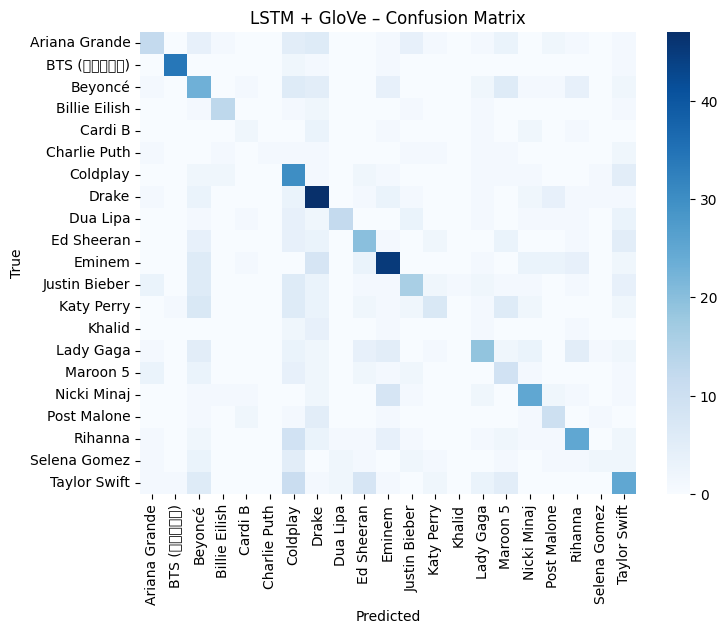

In [ ]:
# ================================================================
# LSTM TRAINING AND EVALUATION (with GloVe embeddings, fixed version)
# ================================================================
import os, requests
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore", category=UserWarning)

# ================================================================
# Encode labels into numeric IDs
# ================================================================
label_enc = LabelEncoder()
y_train_enc = label_enc.fit_transform(y_train_lstm)
y_dev_enc   = label_enc.transform(y_dev_lstm)
y_test_enc  = label_enc.transform(y_test_lstm)
num_classes = len(label_enc.classes_)

# One hot encode target labels for categorical cross-entropy
y_train_cat = to_categorical(y_train_enc, num_classes)
y_dev_cat   = to_categorical(y_dev_enc, num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes)

# ================================================================
# Load pre-trained GloVe embeddings (100-dimensional)
# ================================================================
if not os.path.exists("glove.6B.zip"):
    print("Downloading GloVe embeddings (862 MB)...")
    !wget http://nlp.stanford.edu/data/glove.6B.zip

if not os.path.exists("glove.6B.100d.txt"):
    print("Extracting glove.6B.100d.txt ...")
    !unzip -q glove.6B.zip glove.6B.100d.txt

print("Loading GloVe word embeddings...")
embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
print(f"Loaded {len(embeddings_index):,} word vectors from GloVe.")

# ================================================================
# Build embedding matrix aligned with tokenizer vocabulary
# ================================================================
vocab_size = min(40000, len(tokenizer.word_index) + 1)
EMBED_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBED_DIM))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

print(f"Embedding matrix shape: {embedding_matrix.shape}")

# ================================================================
# Define Bidirectional LSTM architecture with fine-tuned GloVe
# ================================================================
MAX_LEN   = 400
LSTM_UNITS = 256

model = Sequential([
    Embedding(
        input_dim=vocab_size,
        output_dim=EMBED_DIM,
        embeddings_initializer=Constant(embedding_matrix),
        input_length=MAX_LEN,
        trainable=True  # allow fine-tuning of GloVe
    ),

    Bidirectional(LSTM(LSTM_UNITS, dropout=0.3, recurrent_dropout=0.3)),
    BatchNormalization(),

    Dense(128, activation="relu"),
    Dropout(0.4),

    Dense(num_classes, activation="softmax")
])

# ================================================================
# Compile model
# ================================================================
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ================================================================
# Training configuration with callbacks
# ================================================================
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(factor=0.5, patience=2, monitor="val_loss")
]

# ================================================================
# TRAINING FOR A100
# ================================================================
import tensorflow as tf
from tensorflow.keras import mixed_precision

# --- 1. Enabling mixed precision to use Tensor Cores
mixed_precision.set_global_policy('mixed_float16')

# --- 2. Create efficient tf.data pipelines
train_ds = tf.data.Dataset.from_tensor_slices((X_train_pad, y_train_cat))
dev_ds   = tf.data.Dataset.from_tensor_slices((X_dev_pad, y_dev_cat))

BATCH_SIZE = 128  # A100 can easily handle this

train_ds = train_ds.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dev_ds   = dev_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 3. Recompile model
opt = Adam(learning_rate=1e-3)
opt = mixed_precision.LossScaleOptimizer(opt)

model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# --- 4. pipeline
history = model.fit(
    train_ds,
    validation_data=dev_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)


# ================================================================
# Evaluate on test set
# ================================================================
test_loss, test_acc = model.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"[LSTM + GloVe] Test Accuracy = {test_acc:.4f}")

# ================================================================
# Compute weighted F1 score
# ================================================================
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred_enc = np.argmax(y_pred_probs, axis=1)
f1_lstm = f1_score(y_test_enc, y_pred_enc, average="weighted")
print(f"[LSTM + GloVe] Weighted F1 = {f1_lstm:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test_enc, y_pred_enc)
plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap="Blues", annot=False,
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.title("LSTM + GloVe – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



## Assignment Report

**Preprocessing.** After concatenating all 21 artist CSVs that ship in `dataset.zip`, I normalized every lyric by lowercasing, removing punctuation, collapsing whitespace, and trimming blanks. I dropped rows with empty lyrics and eliminated 389 duplicate texts. I used a rule based regex filter that discarded 52 obvious placeholders such as "lyrics coming soon". To catch subtler placeholders, I embedded short lyrics with `all-MiniLM-L6-v2` and dropped 11 rows whose cosine similarity to a placeholder seed list exceeded 0.75. The remaining 5,529 songs were split 70/15/15 (train/dev/test, `random_state=42`). I then produced two parallel views: a lemmatized + stopword-free corpus via spaCy `en_core_web_sm` for models that benefit from lexical normalization, and a cleaned only corpus that keeps stopwords and stylistic quirks for char level features and the LSTM.

**Feature engineering.** The scratch Naive Bayes uses a `CountVectorizer` bag-of-words with unigram-bigram counts (`min_df=3`, 40k vocab) to stay faithful to the MLE derivation. Logistic Regression and Linear SVM consume richer TF-IDF features: (1) a word n-gram space (1-3 grams) to catch topical cues, (2) a `char_wb` 3-5 gram space that captures spelling, emphasis, and punctuation, and (3) their horizontal concatenation ("Hybrid", 80k dims) to blend semantics with style. For the neural baseline, I tokenized the cleaned lyrics with a 40k-word Keras tokenizer, truncated/padded sequences to 400 tokens, and initialized a bidirectional LSTM (256 units) with trainable GloVe-100 embeddings so the model could exploit word order and rhythm.

**Models & results.** The from scratch Multinomial NB (best alpha=0.5) reached 73.5% accuracy / 0.732 weighted F1 on the cleaned corpus, providing a strong lexical baseline. Logistic Regression improved to 80.1% / 0.797 F1 once hybrid TF-IDF features were used, showing that combining semantics and stylistic grams helps linear separators. Linear SVM with the same hybrid features performed best overall at 82.3% accuracy / 0.821 F1, and its confusion matrix shows a tighter diagonal, especially for high-support artists such as Taylor Swift, Drake, and BTS. The BiLSTM lagged at 45.4% / 0.446 F1 despite GloVe initialization; it underfit the long-tail classes and plateaued early even with learning-rate scheduling. These comparisons underline that sparse linear models remain the most data-efficient option for this assignment.

**Challenges.** Implementing Naive Bayes manually required careful handling of sparse matrices to avoid memory blowups, and building the placeholder filter demanded iterative regex tuning plus semantic checks to stop noisy "lyrics coming soon" rows from contaminating training. Training the LSTM on 5k samples also pushed GPU memory, forcing me to adopt mixed precision, tf.data pipelines, and aggressive regularization.

**Limitations & improvements.** Class imbalance (for example Taylor Swift has roughly 10x the rows that Khalid has) still leads to confusion for some artists, and setting lyrics to 400 tokens may cut out repetitions that could help the LSTM. The current TF-IDF features also ignore word order and named entities beyond n-gram scopes. Future work could  upsample or reweight minority artists, add entity-focused or rhyme/tempo features, fine-tune a lightweight transformer like DistilBERT, or maybe a CNN LSTM hybrid to capture longer contexts.
